## Chess AI Sandbox

1. Install
2. Import
3. Run a few turn examples
4. Create simulation
5. Mine for patterns
6. Build a robust decision maker

In [1]:
#!pip install python-chess

    100% |████████████████████████████████| 143kB 3.6MB/s ta 0:00:01
  Running setup.py bdist_wheel for python-chess ... done
  Stored in directory: /Users/laurensuarez/Library/Caches/pip/wheels/fb/f4/8b/d5cea75a8ef7ac965b40d6746331ecce1aa89b739aff4c93d5
Successfully built python-chess
distributed 1.21.8 requires msgpack, which is not installed.
Cache entry deserialization failed, entry ignored
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


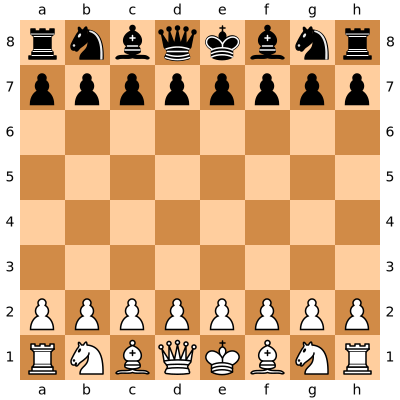

In [1]:
import chess
newBoard = chess.Board()
newBoard

## Randomly move white

[Move.from_uci('g1h3'), Move.from_uci('g1f3'), Move.from_uci('b1c3'), Move.from_uci('b1a3'), Move.from_uci('h2h3'), Move.from_uci('g2g3'), Move.from_uci('f2f3'), Move.from_uci('e2e3'), Move.from_uci('d2d3'), Move.from_uci('c2c3'), Move.from_uci('b2b3'), Move.from_uci('a2a3'), Move.from_uci('h2h4'), Move.from_uci('g2g4'), Move.from_uci('f2f4'), Move.from_uci('e2e4'), Move.from_uci('d2d4'), Move.from_uci('c2c4'), Move.from_uci('b2b4'), Move.from_uci('a2a4')]


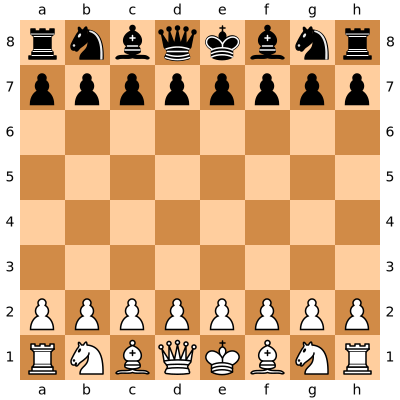

In [2]:
import random

print(list(map(lambda x:x, newBoard.legal_moves)))
randomWhiteMove=random.choice(list(newBoard.legal_moves))
newBoard

## Randomly move black

[Move.from_uci('g1h3'), Move.from_uci('g1f3'), Move.from_uci('b1c3'), Move.from_uci('b1a3'), Move.from_uci('h2h3'), Move.from_uci('g2g3'), Move.from_uci('f2f3'), Move.from_uci('e2e3'), Move.from_uci('d2d3'), Move.from_uci('c2c3'), Move.from_uci('b2b3'), Move.from_uci('a2a3'), Move.from_uci('h2h4'), Move.from_uci('g2g4'), Move.from_uci('f2f4'), Move.from_uci('e2e4'), Move.from_uci('d2d4'), Move.from_uci('c2c4'), Move.from_uci('b2b4'), Move.from_uci('a2a4')]


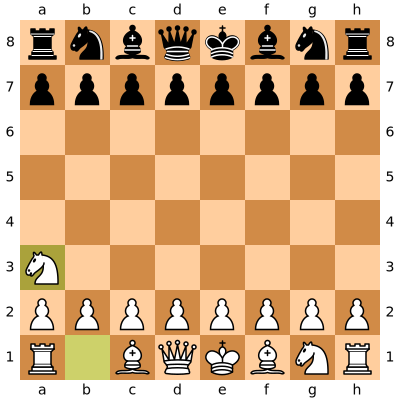

In [3]:
print(list(map(lambda x:x, newBoard.legal_moves)))
randomBlackChoice=random.choice(list(newBoard.legal_moves))
newBoard.push(randomBlackChoice)
newBoard

## Helper functions
How to process and convert data from `python-chess`

## Simulation (Data pipeline)
Record 1000 wins and losses (white perspective)

In [ ]:
class MacOSFile(object):

    def __init__(self, f):
        self.f = f

    def __getattr__(self, item):
        return getattr(self.f, item)

    def read(self, n):
        # print("reading total_bytes=%s" % n, flush=True)
        if n >= (1 << 31):
            buffer = bytearray(n)
            idx = 0
            while idx < n:
                batch_size = min(n - idx, 1 << 31 - 1)
                # print("reading bytes [%s,%s)..." % (idx, idx + batch_size), end="", flush=True)
                buffer[idx:idx + batch_size] = self.f.read(batch_size)
                # print("done.", flush=True)
                idx += batch_size
            return buffer
        return self.f.read(n)

    def write(self, buffer):
        n = len(buffer)
        print("writing total_bytes=%s..." % n, flush=True)
        idx = 0
        while idx < n:
            batch_size = min(n - idx, 1 << 31 - 1)
            print("writing bytes [%s, %s)... " % (idx, idx + batch_size), end="", flush=True)
            self.f.write(buffer[idx:idx + batch_size])
            print("done.", flush=True)
            idx += batch_size

def pickle_dump(obj, file_path):
    with open(file_path, "wb") as f:
        return pickle.dump(obj, MacOSFile(f), protocol=pickle.HIGHEST_PROTOCOL)


def pickle_load(file_path):
    with open(file_path, "rb") as f:
        return pickle.load(MacOSFile(f))

## Helper functions

In [4]:
file_path = "5000_sequences.pkl"
#pickle_dump(turnouts, 'anothertest.pkl')
#turnouts=pickle_load('turnouts.pkl')

import chess
import numpy as np
import random
        
#Winner Lookup
bool2Winner={True:"White",
             False:"Black"}
#Piece Lookup
piece2int={'.':0,'P':chess.PAWN,'R':chess.ROOK,'N':chess.KNIGHT,'B':chess.BISHOP,'Q':chess.QUEEN,'K':chess.KING,
                             'p':chess.PAWN*-1,'r':chess.ROOK*-1,'n':chess.KNIGHT*-1,'b':chess.BISHOP*-1,'q':chess.QUEEN*-1,'k':chess.KING*-1}

domain=list(piece2int.values())
        
#Convert chess value to one_hot encoding
def create_one_hot(pieceId):
    one_hot=[]
    for i,j in enumerate(domain):
        if(j==pieceId):
            one_hot.append(1)
        else:
            one_hot.append(0)
    return np.array(one_hot)

#Construct tensor from matrix
def create_tensor(M):
    rows,cols=M.shape
    T=np.zeros((rows,cols,len(domain)), dtype=np.int)
    for i in range(rows):
        for j in range(cols):
            T[i,j]=create_one_hot(M[i,j])
    return T

#Convert list of list of string board to matrix
#board2Matrix=(lambda someBoard: np.matrix(list(map(lambda x:list(map(lambda y:y.replace(y,str(self.domain)), x.split(" "))), str(someBoard).split("\n"))), dtype=np.int))
def board2Matrix(someBoard):
    return np.matrix(list(map(lambda x:list(map(lambda y:y.replace(y,str(piece2int[y])), x.split(" "))), str(someBoard).split("\n"))), dtype=np.int)

#Convert matrix to tensor
#board2Tensor=(lambda someBoard: create_tensor(board2Matrix(someBoard), self.domain))
def board2Tensor(someBoard):
    return create_tensor(board2Matrix(someBoard))



In [7]:
# Save turnouts
import os
import pickle
#os.chdir("/Users/laurensuarez/Documents/blake/turnouts/")

turnouts={'1-0':[],
          '0-1':[],
          '1/2-1/2':[]}

numGames=5000
# Record 10,000 games each category
simCount=0

while True:
    
    memory=[]
    newBoard = chess.Board()
    sequenceCount=0
    
    while newBoard.is_game_over()==False:
        
        prev_board=str(newBoard)
        move=random.choice(list(newBoard.legal_moves))
        action=str(move)
        #dataPoint=board2Tensor(newBoard)

        memory.append([prev_board,action, None])

        newBoard.push(move)
        
        
        sequenceCount+=1
    
    winner=newBoard.result()
    
    simCount+=1
    
    if simCount % 100 == 0:
        print("Sim count: ", simCount)
        print("Ties: "+str(len(turnouts['1/2-1/2'])))
        print("Wins: "+str(len(turnouts['1-0'])))
        print("Losses: "+str(len(turnouts['0-1'])))
        
    if winner=='1-0':
        print("White won.")
        memory[-1][2]=-1
        turnouts[winner].append(memory)
    elif winner=='0-1':
        print("Black won.")
        memory[-1][2]=1
        turnouts[winner].append(memory)
    else:
        #ignore ties, too many to save
        pass
    
    if len(turnouts['1-0'])>numGames and len(turnouts['0-1']>numGames):
        print("Saving your 5000 games.")
        pickle_dump(turnouts, file_path)
        break

Black won.
White won.
Black won.
White won.
White won.
White won.
White won.
White won.
Black won.
White won.
Black won.
White won.
Black won.
Black won.
White won.
Sim count:  100
Ties: 0
Wins: 9
Losses: 6
Black won.
Black won.
Black won.
White won.
White won.
Black won.
White won.
Black won.
White won.
White won.
White won.
White won.
Black won.
Black won.
Black won.
Black won.
Black won.
Black won.
White won.
Black won.
Sim count:  200
Ties: 0
Wins: 17
Losses: 18
Black won.
Black won.
Black won.
Black won.
Black won.
Black won.
White won.
Black won.
Black won.
Black won.
White won.
Black won.
Black won.
White won.
White won.
Black won.
White won.
Sim count:  300
Ties: 0
Wins: 22
Losses: 30
Black won.
Black won.
Black won.
White won.
White won.
White won.
White won.
White won.
White won.
White won.
Black won.
Black won.
Black won.
Black won.
White won.
Sim count:  400
Ties: 0
Wins: 30
Losses: 37
White won.
White won.
White won.
Black won.
White won.
Black won.
Black won.
White won.
B

White won.
White won.
Sim count:  3900
Ties: 0
Wins: 315
Losses: 273
Black won.
Black won.
White won.
Black won.
White won.
Black won.
Black won.
White won.
Black won.
Black won.
White won.
White won.
White won.
White won.
Sim count:  4000
Ties: 0
Wins: 322
Losses: 280
White won.
White won.
Black won.
Black won.
White won.
White won.
White won.
White won.
Black won.
White won.
Sim count:  4100
Ties: 0
Wins: 329
Losses: 283
White won.
Black won.
White won.
White won.
Black won.
Black won.
Black won.
White won.
Black won.
White won.
Black won.
White won.
White won.
Black won.
White won.
Black won.
Sim count:  4200
Ties: 0
Wins: 337
Losses: 291
Black won.
Black won.
Black won.
White won.
White won.
White won.
Black won.
Black won.
Black won.
White won.
Black won.
White won.
Black won.
White won.
White won.
Black won.
White won.
Sim count:  4300
Ties: 0
Wins: 345
Losses: 300
Black won.
Black won.
Black won.
Black won.
White won.
White won.
White won.
Black won.
White won.
Black won.
Black 

White won.
White won.
Black won.
Black won.
Black won.
Black won.
Sim count:  7800
Ties: 0
Wins: 600
Losses: 571
Black won.
Black won.
White won.
White won.
White won.
Black won.
Black won.
Black won.
Black won.
White won.
White won.
White won.
Black won.
White won.
Sim count:  7900
Ties: 0
Wins: 607
Losses: 578
White won.
White won.
Black won.
White won.
Black won.
Black won.
Black won.
White won.
Black won.
White won.
Black won.
Black won.
White won.
White won.
White won.
White won.
Black won.
White won.
White won.
Black won.
White won.
Sim count:  8000
Ties: 0
Wins: 619
Losses: 587
Black won.
White won.
Black won.
Black won.
Black won.
White won.
Black won.
White won.
Black won.


KeyboardInterrupt: 

<class 'list'>
[['. . . . . . . .\n. . r . . . . .\n. . . . p . k .\n. . . . . . . n\n. . . . . . . .\n. . . . . . . .\n. . . . . . R .\n. . . . . . . K', 'b8c6', 0], ['. . . . . . . .\n. . r . . . . .\n. . . . p . k .\n. . . . . . . n\n. . . . . . . .\n. . . . . . . .\n. . . . . . R .\n. . . . . . . K', 'e2e3', 0], ['. . . . . . . .\n. . r . . . . .\n. . . . p . k .\n. . . . . . . n\n. . . . . . . .\n. . . . . . . .\n. . . . . . R .\n. . . . . . . K', 'f7f5', 0], ['. . . . . . . .\n. . r . . . . .\n. . . . p . k .\n. . . . . . . n\n. . . . . . . .\n. . . . . . . .\n. . . . . . R .\n. . . . . . . K', 'f1c4', 0], ['. . . . . . . .\n. . r . . . . .\n. . . . p . k .\n. . . . . . . n\n. . . . . . . .\n. . . . . . . .\n. . . . . . R .\n. . . . . . . K', 'c6e5', 0], ['. . . . . . . .\n. . r . . . . .\n. . . . p . k .\n. . . . . . . n\n. . . . . . . .\n. . . . . . . .\n. . . . . . R .\n. . . . . . . K', 'c4e2', 0], ['. . . . . . . .\n. . r . . . . .\n. . . . p . k .\n. . . . . . . n\n. . . . 

KeyboardInterrupt: 

In [17]:
s=set([1,2,3])
s.add(5)
s

{1, 2, 3, 5}

## Data Processing (Cleaning)
Convert list of tensors to a supervised data set

In [9]:
import os
import pickle
import numpy as np
os.chdir("/Users/laurensuarez/Documents/blake/turnouts/")

class MacOSFile(object):

    def __init__(self, f):
        self.f = f

    def __getattr__(self, item):
        return getattr(self.f, item)

    def read(self, n):
        # print("reading total_bytes=%s" % n, flush=True)
        if n >= (1 << 31):
            buffer = bytearray(n)
            idx = 0
            while idx < n:
                batch_size = min(n - idx, 1 << 31 - 1)
                # print("reading bytes [%s,%s)..." % (idx, idx + batch_size), end="", flush=True)
                buffer[idx:idx + batch_size] = self.f.read(batch_size)
                # print("done.", flush=True)
                idx += batch_size
            return buffer
        return self.f.read(n)

    def write(self, buffer):
        n = len(buffer)
        print("writing total_bytes=%s..." % n, flush=True)
        idx = 0
        while idx < n:
            batch_size = min(n - idx, 1 << 31 - 1)
            print("writing bytes [%s, %s)... " % (idx, idx + batch_size), end="", flush=True)
            self.f.write(buffer[idx:idx + batch_size])
            print("done.", flush=True)
            idx += batch_size

def pickle_dump(obj, file_path):
    with open(file_path, "wb") as f:
        return pickle.dump(obj, MacOSFile(f), protocol=pickle.HIGHEST_PROTOCOL)


def pickle_load(file_path):
    with open(file_path, "rb") as f:
        return pickle.load(MacOSFile(f))

turnouts=pickle_load('turnouts.pkl')
len(turnouts['1-0'])

1001

In [21]:
# First random winning game sequence of board states, which took 102 moves to finish
turnouts['1-0'][0]

[(10, 0, array([[[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]],
  
         [[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]],
  
         [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [1, 0,

In [ ]:
winningTensorsList=list(map(lambda x:x[0][2], turnouts['1-0']))
WwinReward=np.array([1 for i in range(len(winningTensorsList))], np.int)
BwinReward=np.array([-1 for i in range(len(winningTensorsList))], np.int)

losingTensorsList=list(map(lambda x:x[0][2], turnouts['0-1']))
WlosingReward=np.array([-1 for i in range(len(losingTensorsList))], np.int)
BlosingReward=np.array([1 for i in range(len(losingTensorsList))], np.int)

tieingTensorsList=list(map(lambda x:x[0][2], turnouts['1/2-1/2']))
WtieingReward=np.array([0 for i in range(len(tieingTensorsList))], np.int)
BtieingReward=np.array([0 for i in range(len(tieingTensorsList))], np.int)

N=len(winningTensorsList)+len(losingTensorsList)+len(tieingTensorsList)
df=np.ndarray((N, 
                           winningTensorsList[0].shape[0],
                           winningTensorsList[0].shape[1],
                           winningTensorsList[0][0].shape[1]))
for i in range(len(winningTensorsList)):
    df[i]=winningTensorsList[i]

Wrewards=np.hstack((WwinReward,WlosingReward,WtieingReward))
Brewards=np.hstack((BwinReward,BlosingReward,BtieingReward))

"""from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(rewards)
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
rewards = onehot_encoder.fit_transform(integer_encoded)"""

print(Wrewards.shape)
print(df.shape)

X=df
yW=Wrewards
yB=Brewards

from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, yW, test_size=0.33, shuffle=True, random_state=42)


## Data Analysis (Observations)
Initial insights from analyst experience 

In [181]:
import tensorflow as tf
import torch

def getEqualities(df):
    comparisons=[]
    for i in range(len(df)):
        t=torch.tensor(df[i])
        tmp=[]
        for j in range(len(df)):
            t2=torch.tensor(df[j])
            tmp.append(t.equal(t2))
        comparisons.append(tmp)
    return comparisons

#comparisons=getEqualities(df)
np.matrix(comparisons, dtype=np.int)

matrix([[1, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1]])

## Data Mining (Insight Extraction)

<strong>Build The Net</strong>

- ID each unique board state found in the winning games (from white perspective); Don't forget from black perspective when AI building, just look at the losses as wins.

- Create a `board state vocabulary` accross all winning games; Every unique board state from all sequences

- Generate a new dataframe `D` whose rows are games and columns are the board states in the vocabulary; This matrix will be lit with `1` if a particular row (game) contained that board state, otherwise 0. 

            +------------+------------+------++-----------+
            |boardState0 |boardState1 | .... |boardStateD |
            +------------+------------+------++-----------+
      game1 |_____1____________0________...._______1______|
      game2 |_____1____________1________...._______1______|
      ...   |___________________________....______________|
      gameN |_____0____________0________...._______0______|
      

In [170]:
import tensorflow
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from keras.losses import mean_squared_error
import numpy
numpy.random.seed(7)

X=df
y=rewards

from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)
Xtrain, Xvalid, ytrain, yvalid = train_test_split(Xtest, ytest, test_size=0.33, shuffle=True, random_state=42)

print("X")
print(Xtrain.shape)
print(Xtest.shape)
print(Xvalid.shape)

print("y")
print(ytrain.shape)
print(ytest.shape)
print(yvalid.shape)

model = Sequential()
model.add(Conv2D(32, kernel_size=(6, 6), strides=(1, 1),
                 activation='relu',
                 input_shape=(8,8,13)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dense(1028, activation='sigmoid'))
model.add(Dense(1028, activation='sigmoid'))
model.add(Dense(1028, activation='sigmoid'))
model.add(Dense(1028, activation='sigmoid'))
model.add(Dense(1028, activation='sigmoid'))
model.add(Flatten())
model.add(Dense(1028, activation='tanh'))
model.add(Dense(3, activation='sigmoid'))

model.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer=keras.optimizers.SGD(lr=0.01), 
              metrics=['accuracy'])
        
model.fit(Xtrain, ytrain,
          #batch_size=batch_size,
          #epochs=epochs,
          verbose=1,
          validation_data=(Xtest, ytest),
          #callbacks=[history]
         )

score = model.evaluate(Xvalid, yvalid, verbose=0)
print('Test loss:', score)

X
(663, 8, 8, 13)
(991, 8, 8, 13)
(328, 8, 8, 13)
y
(663, 3)
(991, 3)
(328, 3)
Train on 663 samples, validate on 991 samples
Epoch 1/1
663/663 [==============================] - 6s 9ms/step - loss: 1.1100 - acc: 0.3062 - val_loss: 1.1036 - val_acc: 0.3310
Test loss: [1.1100700308636922, 0.3567073170731707]


In [180]:
model.predict( np.expand_dims(Xtest[901],axis=0))

array([[0.45331684, 0.5930618 , 0.58468866]], dtype=float32)

In [ ]:
memory=[]
newBoard = chess.Board()
sequenceCount=0

while newBoard.is_game_over()==False:
    
    points=[]
    for m in list(newBoard.legal_moves):
        newBoard.push(move)
        dataPoint=board2Tensor(newBoard)
        points.append(dataPoint)
        newBoard.pop()
    
    
    dataPoint=board2Tensor(newBoard)
    memory.append((simCount,sequenceCount, dataPoint))

    sequenceCount+=1

Test loss: 0.5425103306770325


In [32]:
X.shape

(33, 8, 8, 13, 1)

## Genetic Learning (100 step competition)

<strong>Init step:</strong>

Train AI_0 and AI_1 on 10,000 diversified samples

Let `i=0`

<strong>Algorithm step:</strong>

while #losses(AI_i+1)>0

    Let AI_i+1=AI_1

    Let AI_i play vs. AI_i+1 100 times

    Save the games

    Let AI_w = argmax(#wins(AI_i), #wins(AI_i+1))

    Retrain the winner on the wins, losses, and ties.

    Let AI_i+1=AI_w

    Let i=i+1

    Continue

When this converges you have an AI at the end of the list who has lost no matches. Should be pretty good.


In [ ]:
memory=[]
newBoard = chess.Board()
sequenceCount=0

while newBoard.is_game_over()==False:

    move=random.choice(list(newBoard.legal_moves))
    newBoard.push(move)
    
    
    # for each choice
        # push, evaluate board probability
        # append to probs
        # pop
    # i = argmax(probs)
    # move = list(newBoard.legal_moves[i])
    
    dataPoint=board2Tensor(newBoard)
    memory.append((simCount,sequenceCount, dataPoint))

    sequenceCount+=1

winner=newBoard.result()

## Monte Carlo
### Reinforcement Learning

1. Bellman Equation
2. Policy Iteration Algorithm
3. Value Iteration Algorithm

In [93]:
import datetime
import os
os.chdir("/Users/laurensuarez/Documents/blake/chess/data")
def random_action(theBoard, thePolicy, eps=0.1):
    
    # Current state
    s=str(theBoard)
    
    #   ///////////////////
    #  // If Unexplored //
    # ///////////////////
    if s not in list(thePolicy.keys()): 
        return np.random.choice(list(theBoard.legal_moves))
    
    #   ////////////////////
    #  // Epsilon-greedy //
    # ////////////////////
    p=np.random.random() # [0,1]    
    
    #   /////////////
    #  // Exploit //
    # /////////////
    if p < (1-eps):
        selected=None
        a=thePolicy[s]
        for act in list(theBoard.legal_moves):
            #print(str(act))
            if str(act) == a:
                selected=act
                
        #   /////////////
        #  // Explore //
        # //////////////
        if selected is None:
            # The possibility of being in a state that had an option
            # but is now currently preoccupied by a piece, or check conditions, ect..
            # hence, just move randomly, treat it as if we do not have an option.
            return np.random.choice(list(theBoard.legal_moves))
        else:
            return selected
        
    #   /////////////
    #  // Explore //
    # //////////////
    else:
        return np.random.choice(list(theBoard.legal_moves))

# Play game as black
def play_game(theBoard, thePolicy, gamma=0.9):
        
    #   //////////////////////
    #  // White Move First //
    # //////////////////////
    move=np.random.choice(list(theBoard.legal_moves))
    theBoard.push(move)
    
    #   //////////////
    #  // Game on! //
    # //////////////
    state_action_rewards=[]
    while theBoard.is_game_over()==False:
        
        # Make intelligent move from policy (iteratively updated)
        state=str(theBoard)
        move=random_action(theBoard, thePolicy)
        action=str(move)
        state_action_rewards.append([state,action,0])
        theBoard.push(move)
    
    # Allocate winner points
    winner=newBoard.result()
    if winner == '1-0':
        # We lost
        state_action_rewards[-1][2]=-1
    elif winner == '0-1':
        # We won!
        state_action_rewards[-1][2]=1
    else:
        # Tie...
        state_action_rewards[-1][2]=0.001
        pass
    
    #   /////////////////////////////
    #  // Bellman Update Equation //
    # /////////////////////////////
    G = 0
    states_actions_returns = []

    for s,a,r in reversed(state_action_rewards):

        states_actions_returns.append((s, a, G))
        G = r + gamma*G
    states_actions_returns.reverse()
    
    return states_actions_returns
    
policy={}
Q=defaultdict(dict)
returns=defaultdict(list)
def run_simulation(num_games=5000, write_file_mod=200):

    #   //////////////////////
    #  // Agent Containers //
    # //////////////////////
    policy={}
    Q=defaultdict(dict)
    returns=defaultdict(list)

    #   //////////////////////
    #  // Simulation Begin //
    # //////////////////////
    deltas=[]
    seen_state_action_pairs=set()
    for i in range(num_games):
        
        if i % write_file_mod == 0 and i != 0:
            print(i)
            custom_time=str(datetime.datetime.now()).replace(".","_").replace(":","_").replace(" ", "")
            if not os.path.exists(os.path.join(os.getcwd(),custom_time)):
                os.makedirs(os.path.join(os.getcwd(),custom_time))
            pickle_dump(Q, custom_time+"/Q_"+custom_time+".pkl")
            pickle_dump(Q, custom_time+"/policy_"+custom_time+".pkl")
            pickle_dump(Q, custom_time+"/V_"+custom_time+".pkl")
        #Fresh board
        newBoard=chess.Board()
        
        #For visualization
        biggest_change=0
        
        #Collect 1 game sequence 
        state_action_returns_list=play_game(newBoard, policy)
        
        #   ///////////////////////////
        #  // Value function update //
        # ///////////////////////////
        for s, a, G in state_action_returns_list:
            sa = (s, a)
            if sa in seen_state_action_pairs:
                old_q=Q[s][a]
            elif sa not in seen_state_action_pairs:
                old_q=0
                seen_state_action_pairs.add(sa)
            else:
                print("Error: (s,a) is niether been seen in the past nor has it not been seen. Huge problem.")
            returns[sa].append(G)
            Q[s][a]=np.mean(returns[sa]) #rolling mean, Q now `learns`
            biggest_change=max([biggest_change, np.abs(old_q - Q[s][a])])
            deltas.append(biggest_change)
            
            
        #   ///////////////////
        #  // Policy Update //
        # ///////////////////
        for s in Q.keys():
            keys=list(Q[s].keys())
            vals=list(Q[s].values())
            a = keys[np.argmax(vals)]
            policy[s] = a
    V = {}
    for s in policy.keys():
        V[s] = Q[s][1]
    return Q, policy, V, deltas
                                

In [ ]:
import matplotlib.pyplot as plt
Q,policy,V,deltas=run_simulation(num_games=5000, write_file_mod=200)
plt.plot(deltas)
plt.show


200
writing total_bytes=10764744...
writing bytes [0, 10764744)... done.
writing total_bytes=10764744...
writing bytes [0, 10764744)... done.
writing total_bytes=10764744...
writing bytes [0, 10764744)... done.
400
writing total_bytes=21846340...
writing bytes [0, 21846340)... done.
writing total_bytes=21846340...
writing bytes [0, 21846340)... done.
writing total_bytes=21846340...
writing bytes [0, 21846340)... done.
600
writing total_bytes=32485884...
writing bytes [0, 32485884)... done.
writing total_bytes=32485884...
writing bytes [0, 32485884)... done.
writing total_bytes=32485884...
writing bytes [0, 32485884)... done.
800
writing total_bytes=43107046...
writing bytes [0, 43107046)... done.
writing total_bytes=43107046...
writing bytes [0, 43107046)... done.
writing total_bytes=43107046...
writing bytes [0, 43107046)... done.
1000
writing total_bytes=53718757...
writing bytes [0, 53718757)... done.
writing total_bytes=53718757...
writing bytes [0, 53718757)... done.
writing total

## Approximation Functions

Since we know the size of a dictionary in python is limited. The better strategy is to learn the value function using deep learning techniques, so we can obtain high quality predictions `f(state, params)=value`.

We now seek to build a model that can predict the value function, rather than just storing them in a value dictionary with a policy.

This integrates supervised learning into reinforcement learning.

$$ error = (value_{true}-value_{pred})^2$$
$$ error = (E[G(t) | S_t = s]-value_{pred})^2$$
$$ error = (\dfrac{1}{N}\sum\limits_{k=1}^n G_{i,s} - value_{pred})^2$$

So each run in our simulation becomes a training point:

$$ error = \sum\limits_{k=1}^n (y_i -\hat{y_i})^2$$

When using linear methods to find the transformation of a state, you must manually do feature engineering. However, when using non-linear methods such as deep neural networks (which are also differentiable), we can allow them to construct the features that are most important. So we continue with the simple linear case and construct features for our board states.

One way to do this is to `one_hot_encode` by each of our states. A lot like time series data as a categorical variable. This blows up in dimensionality, so this really isn't any improvement. The positive to this is that you can clearly explain what the problem is, your model or your features. 

Another approach is to model your board as the raw data itself; a tensor. Construct a tensor transformation and make the data (8,8,14), representing each piece of the board and which piece currently occupies it (or if none do). This is also a challenge. 

Yet another approach is to apply `Taylor Series Expansion`, which contains the capability to approximate any real valued function using sum of polynomials. This could be done using `w=f(x,y,z)=x**2+y**2+z**2`. The possibilities are endless here if you are using a linear model.

We can manually apply gradient descent to optimize our linear model.



In [82]:
import datetime
import os
os.chdir("/Users/laurensuarez/Documents/blake/chess/data")
def random_action(theBoard, thePolicy, eps=0.1):
    
    # Current state
    s=str(theBoard)
    
    #   ///////////////////
    #  // If Unexplored //
    # ///////////////////
    if s not in list(thePolicy.keys()): 
        return np.random.choice(list(theBoard.legal_moves))
    
    #   ////////////////////
    #  // Epsilon-greedy //
    # ////////////////////
    p=np.random.random() # [0,1]    
    
    #   /////////////
    #  // Exploit //
    # /////////////
    if p < (1-eps):
        selected=None
        a=thePolicy[s]
        for act in list(theBoard.legal_moves):
            #print(str(act))
            if str(act) == a:
                selected=act
                
        #   /////////////
        #  // Explore //
        # //////////////
        if selected is None:
            # The possibility of being in a state that had an option
            # but is now currently preoccupied by a piece, or check conditions, ect..
            # hence, just move randomly, treat it as if we do not have an option.
            return np.random.choice(list(theBoard.legal_moves))
        else:
            return selected
        
    #   /////////////
    #  // Explore //
    # //////////////
    else:
        return np.random.choice(list(theBoard.legal_moves))

# Play game as black
def play_game(theBoard, thePolicy, gamma=0.9):
        
    #   //////////////////////
    #  // White Move First //
    # //////////////////////
    move=np.random.choice(list(theBoard.legal_moves))
    theBoard.push(move)
    
    #   //////////////
    #  // Game on! //
    # //////////////
    state_action_rewards=[]
    while theBoard.is_game_over()==False:
        
        # Make intelligent move from policy (iteratively updated)
        state=str(theBoard)
        move=random_action(theBoard, thePolicy)
        action=str(move)
        state_action_rewards.append([state,action,0])
        theBoard.push(move)
    
    # Allocate winner points
    winner=newBoard.result()
    if winner == '1-0':
        # We lost
        state_action_rewards[-1][2]=-1
    elif winner == '0-1':
        # We won!
        state_action_rewards[-1][2]=1
    else:
        # Tie...
        state_action_rewards[-1][2]=0.001
        pass
    
    #   /////////////////////////////
    #  // Bellman Update Equation //
    # /////////////////////////////
    G = 0
    states_actions_returns = []

    for s,a,r in reversed(state_action_rewards):

        states_actions_returns.append((s, a, G))
        G = r + gamma*G
    states_actions_returns.reverse()
    
    return states_actions_returns
    
policy={}
Q=defaultdict(dict)
returns=defaultdict(list)
def run_simulation_approx(num_games=5000, write_file_mod=200, alpha=0.001):

    #   //////////////////////
    #  // Agent Containers //
    # //////////////////////
    policy={}
    Q=defaultdict(dict)
    returns=defaultdict(list)

    
    #     ////////////////////////////////////////////
    #    // Linear Value Function Approximation    //
    #   // Kernel Function                        //
    #  // Transform state (8,8,13) into vector   //
    # ////////////////////////////////////////////
    theta=np.random.rand(4)/2
    def s2x(s):
        piece_ratio=np.divide(np.sum([i.islower() for i in L]),np.sum(i.isupper() for i in L))
        black_count=np.sum([i.islower() for i in L])
        white_count=np.sum([i.isupper() for i in L])
        bias=1.0
        return np.array([piece_ratio,
                         black_count,
                         white_count,
                         bias])
    
    #   //////////////////////
    #  // Simulation Begin //
    # //////////////////////
    deltas=[]
    seen_states=set()
    t=1.0
    for i in range(num_games):
        
        #Decaying learning rate
        alpha/=t
        
        if i % write_file_mod == 0 and i != 0:
            print(i)
            custom_time=str(datetime.datetime.now()).replace(".","_").replace(":","_").replace(" ", "")
            if not os.path.exists(os.path.join(os.getcwd(),custom_time)):
                os.makedirs(os.path.join(os.getcwd(),custom_time))
            pickle_dump(Q, custom_time+"/Q_"+custom_time+".pkl")
            pickle_dump(Q, custom_time+"/policy_"+custom_time+".pkl")
            pickle_dump(Q, custom_time+"/V_"+custom_time+".pkl")
            
            #Update learning decay rate
            t+=0.01
        
        #Fresh board
        newBoard=chess.Board()
        
        #For visualization
        biggest_change=0
        
        #Collect 1 game sequence 
        state_action_returns_list=play_game(newBoard, policy)
        
        #   ///////////////////////////
        #  // Value function update //
        # ///////////////////////////
        for s, a, G in state_action_returns_list:
            
            # For every state, regardless of whether we have seen
            # it or not, we should be able to just use previous
            # knowledge, or simply update from the past if we
            # see the same state in context, so this is where
            # I deviate a bit from the traditional algorithm.
            old_theta=theta.copy()
            x=s2x(s)
            V_hat=theta.dot(x)
            #grad(V_hat w.r.t theta=x)
            theta+=alpha*(G-V_hat)*x
            biggest_change=max([biggest_change, np.abs(old_theta - theta).sum()])
            seen_states.add(s)
            deltas.append(biggest_change)
            
        
    #   //////////////////
    #  // Value Update //
    # //////////////////
    V = {}
    for s in seen_states:
        V[s] = theta.dot(s2x(s))
    return V, theta, deltas
                                


'2018-11-2421_39_37_675256'

In [ ]:
V,theta,deltas=run_simulation_approx(alpha=0.005)